In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import re

In [3]:
fuzzy_df = pd.read_csv('/kaggle/input/Fuzzy_dataset.csv')
fuzzy_df.columns = ['Timestamp', 'CAN ID', 'DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']
fuzzy_df.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478196e+09,02b0,5,ff,7f,00,05,49,R,NaN,NaN,NaN
1,1.478196e+09,0002,8,00,00,00,00,00,01,07,15,R
2,1.478196e+09,0153,8,00,21,10,ff,00,ff,00,00,R
3,1.478196e+09,0130,8,19,80,00,ff,fe,7f,07,60,R
4,1.478196e+09,0131,8,17,80,00,00,65,7f,07,9f,R


In [5]:
fuzzy_df.nunique()

Timestamp    3838859
CAN ID          2048
DLC                4
DATA0            256
DATA1            256
DATA2            257
DATA3            256
DATA4            256
DATA5            257
DATA6            257
DATA7            256
Flag               2
dtype: int64

In [6]:
df_2 = fuzzy_df.copy()

In [7]:
df_2['DLC'].unique()

array([5, 8, 2, 6])

In [8]:
missing_values = df_2.isnull().sum()
missing_values

Timestamp        0
CAN ID           0
DLC              0
DATA0            0
DATA1            0
DATA2            0
DATA3        34382
DATA4        34382
DATA5        34382
DATA6        87833
DATA7        87836
Flag         87836
dtype: int64

In [9]:
df_dlc_is_2 = df_2[df_2["DLC"] == 2].copy()
df_dlc_is_2.head(), df_dlc_is_2.shape

(        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
 79   1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 174  1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 274  1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 369  1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 469  1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 
     Flag  
 79   NaN  
 174  NaN  
 274  NaN  
 369  NaN  
 469  NaN  ,
 (34382, 12))

In [10]:
df_d2_nan = df_2[df_2["DATA2"] == 'R'].copy()
df_d2_nan.head(), df_d2_nan.shape

(        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
 79   1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 174  1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 274  1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 369  1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 469  1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 
     Flag  
 79   NaN  
 174  NaN  
 274  NaN  
 369  NaN  
 469  NaN  ,
 (34382, 12))

In [11]:
df_flag_nan = df_2[(df_2["Flag"] != "T") & (df_2["Flag"] != "R")]
df_flag_nan.head(10), df_flag_nan.shape

(        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
 0    1.478196e+09   02b0    5    ff    7f    00    05    49     R   NaN   NaN   
 18   1.478196e+09   02b0    5    ff    7f    00    05    7a     R   NaN   NaN   
 41   1.478196e+09   02b0    5    ff    7f    00    05    6b     R   NaN   NaN   
 59   1.478196e+09   02b0    5    ff    7f    00    05    1c     R   NaN   NaN   
 79   1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 80   1.478196e+09   02b0    5    ff    7f    00    05    0d     R   NaN   NaN   
 98   1.478196e+09   02b0    5    ff    7f    00    05    3e     R   NaN   NaN   
 118  1.478196e+09   02b0    5    ff    7f    00    05    2f     R   NaN   NaN   
 136  1.478196e+09   02b0    5    ff    7f    00    05    d0     R   NaN   NaN   
 156  1.478196e+09   02b0    5    ff    7f    00    05    c1     R   NaN   NaN   
 
     Flag  
 0    NaN  
 18   NaN  
 41   NaN  
 59   NaN  
 79   NaN  
 80   NaN  
 98   NaN  


In [11]:
df_3 = df_2.copy()

In [12]:
import pandas as pd
import numpy as np

def move_r_to_flag_and_fill(df, dlc_value, data_column, fill_columns, fill_value='00'):
    """
    Moves 'R' from the specified DATA column to the Flag column for rows with the given DLC value.
    Fills NaN values in specified columns with the given fill value.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to modify.
        dlc_value (int): The DLC value to filter rows.
        data_column (str): The DATA column from which to move 'R'.
        fill_columns (list): List of columns to fill NaN values in.
        fill_value (str): The value to fill NaN with (default is '00').
    
    Returns:
        pd.DataFrame: The modified DataFrame.
    """
    # Create a mask for rows with the specified DLC value
    mask = df["DLC"] == dlc_value
    
    # Move 'R' from the specified DATA column to Flag
    df.loc[mask, "Flag"] = df.loc[mask, data_column]
    
    # Set the original DATA column to NaN for the specified rows
    df.loc[mask, data_column] = np.nan
    
    # Fill NaN with the specified fill value in the specified columns
    df[fill_columns] = df[fill_columns].fillna(fill_value)
    
    return df

# Columns to fill with '00'
data_columns = ['DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']

# Apply the function for DLC=2, DLC=5, and DLC=6
df_3 = move_r_to_flag_and_fill(df_3, dlc_value=2, data_column="DATA2", fill_columns=data_columns)
df_3 = move_r_to_flag_and_fill(df_3, dlc_value=5, data_column="DATA5", fill_columns=data_columns)
df_3 = move_r_to_flag_and_fill(df_3, dlc_value=6, data_column="DATA6", fill_columns=data_columns)

# Verify the results
print("DLC=2 in df_3:")
print(df_3[df_3["DLC"] == 2].head())

print("DLC=5 in df_3:")
print(df_3[df_3["DLC"] == 5].head())

print("DLC=6 in df_3:")
print(df_3[df_3["DLC"] == 6].head())

DLC=2 in df_3:
        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
79   1.478196e+09   05f0    2    00    00    00    00    00    00    00    00   
174  1.478196e+09   05f0    2    00    00    00    00    00    00    00    00   
274  1.478196e+09   05f0    2    00    00    00    00    00    00    00    00   
369  1.478196e+09   05f0    2    00    00    00    00    00    00    00    00   
469  1.478196e+09   05f0    2    00    00    00    00    00    00    00    00   

    Flag  
79     R  
174    R  
274    R  
369    R  
469    R  
DLC=5 in df_3:
       Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
0   1.478196e+09   02b0    5    ff    7f    00    05    49    00    00    00   
18  1.478196e+09   02b0    5    ff    7f    00    05    7a    00    00    00   
41  1.478196e+09   02b0    5    ff    7f    00    05    6b    00    00    00   
59  1.478196e+09   02b0    5    ff    7f    00    05    1c    00    00    00   
80  1.478196e+09 

In [13]:
df_4 = df_3.copy()

In [14]:
df_4.head(), df_4.shape

(      Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
 0  1.478196e+09   02b0    5    ff    7f    00    05    49    00    00    00   
 1  1.478196e+09   0002    8    00    00    00    00    00    01    07    15   
 2  1.478196e+09   0153    8    00    21    10    ff    00    ff    00    00   
 3  1.478196e+09   0130    8    19    80    00    ff    fe    7f    07    60   
 4  1.478196e+09   0131    8    17    80    00    00    65    7f    07    9f   
 
   Flag  
 0    R  
 1    R  
 2    R  
 3    R  
 4    R  ,
 (3838859, 12))

In [15]:
df_4[(df_4["Flag"] != "T") & (df_4["Flag"] != "R")]


,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag


In [16]:
df_4[df_4["DATA2"] == 'R'].head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag


In [17]:
# Drop unnecessary columns
df_drop_dlc = df_4.drop(["DLC"], axis=1).copy()
df_drop_dlc.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478196e+09,02b0,ff,7f,00,05,49,00,00,00,R
1,1.478196e+09,0002,00,00,00,00,00,01,07,15,R
2,1.478196e+09,0153,00,21,10,ff,00,ff,00,00,R
3,1.478196e+09,0130,19,80,00,ff,fe,7f,07,60,R
4,1.478196e+09,0131,17,80,00,00,65,7f,07,9f,R


In [18]:
df_drop_dlc.dtypes, df_drop_dlc.shape

(Timestamp    float64
 CAN ID        object
 DATA0         object
 DATA1         object
 DATA2         object
 DATA3         object
 DATA4         object
 DATA5         object
 DATA6         object
 DATA7         object
 Flag          object
 dtype: object,
 (3838859, 11))

In [19]:
df_6 = df_drop_dlc.copy()

df_drop_timestamp = df_drop_dlc.drop(columns=['Timestamp'], inplace=False).copy()
df_drop_timestamp.describe()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
count,3838859,3838859,3838859,3838859,3838859,3838859,3838859,3838859,3838859,3838859
unique,2048,256,256,256,256,256,256,256,256,2
top,0316,00,00,00,00,00,00,00,00,R
freq,182121,1141824,1375200,1982150,1497877,1489162,1136017,1857470,1753764,3347012


In [20]:
data_columns = ['DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7']

# Create regex pattern for valid hex
hex_pattern = r'^[0-9A-Fa-f]{2}$'

# Check for non-hex values
mask = df_6[data_columns].apply(lambda col: ~col.str.match(hex_pattern, na=False))

# Get rows with any invalid entries
invalid_rows = df_6[mask.any(axis=1)]

print("Rows with non-hex values in DATA columns:")
print(invalid_rows if not invalid_rows.empty else "No non-hex values found")

Rows with non-hex values in DATA columns:
No non-hex values found


In [22]:
df_7 = df_6.copy()
# Function to convert hex to decimal
def hex_to_int(hex_str: str) -> int:
    try:
        return int(str(hex_str).strip(), 16)  # Convert hex to int
    except ValueError:
        return np.nan 

# Convert all DATA columns
for col in df_7.columns[1:-1]:  # Exclude 'Timestamp' and 'Flag' column
    df_7[col] = df_7[col].apply(hex_to_int)

df_7.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478196e+09,688,255,127,0,5,73,0,0,0,R
1,1.478196e+09,2,0,0,0,0,0,1,7,21,R
2,1.478196e+09,339,0,33,16,255,0,255,0,0,R
3,1.478196e+09,304,25,128,0,255,254,127,7,96,R
4,1.478196e+09,305,23,128,0,0,101,127,7,159,R


In [23]:
df_8 = df_7.copy()

In [24]:
df_8["Flag"] = df_8["Flag"].map({"R": 0, "T": 1})
df_8.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478196e+09,688,255,127,0,5,73,0,0,0,0
1,1.478196e+09,2,0,0,0,0,0,1,7,21,0
2,1.478196e+09,339,0,33,16,255,0,255,0,0,0
3,1.478196e+09,304,25,128,0,255,254,127,7,96,0
4,1.478196e+09,305,23,128,0,0,101,127,7,159,0


In [25]:
df_8["Flag"].unique()

array([0, 1])

In [26]:
df_8.isna().sum()

Timestamp    0
CAN ID       0
DATA0        0
DATA1        0
DATA2        0
DATA3        0
DATA4        0
DATA5        0
DATA6        0
DATA7        0
Flag         0
dtype: int64

In [27]:
df_8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3838859 entries, 0 to 3838858
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   CAN ID     int64  
 2   DATA0      int64  
 3   DATA1      int64  
 4   DATA2      int64  
 5   DATA3      int64  
 6   DATA4      int64  
 7   DATA5      int64  
 8   DATA6      int64  
 9   DATA7      int64  
 10  Flag       int64  
dtypes: float64(1), int64(10)
memory usage: 322.2 MB


In [28]:
df_8.describe()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
count,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06
mean,1.478198e+09,7.445983e+02,6.984423e+01,5.546538e+01,4.821561e+01,7.159755e+01,5.796316e+01,7.495730e+01,3.854785e+01,5.749925e+01,1.281232e-01
std,1.837432e+03,4.221483e+02,9.449050e+01,6.351706e+01,6.628019e+01,9.282874e+01,7.764405e+01,8.303548e+01,6.780185e+01,7.572350e+01,3.342270e-01
min,1.478196e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.478196e+09,3.390000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.478197e+09,7.040000e+02,2.000000e+01,3.300000e+01,0.000000e+00,2.000000e+01,1.700000e+01,3.300000e+01,2.000000e+00,1.900000e+01,0.000000e+00
75%,1.478198e+09,1.087000e+03,1.330000e+02,9.100000e+01,9.600000e+01,1.280000e+02,1.190000e+02,1.280000e+02,3.800000e+01,1.110000e+02,0.000000e+00
max,1.478201e+09,2.047000e+03,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,1.000000e+00


In [ ]:
# df_8.to_csv('/kaggle/working/cleaned_data.csv', index=False)

# print("Data saved successfully as 'cleaned_data.csv'.")

In [29]:
# Exclude the 'Flag' column before calculating correlation
correlation_matrix = df_8.drop(columns=['Timestamp', 'CAN ID', 'Flag']).corr()
correlation_matrix

,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7
DATA0,1.000000,0.270694,-0.017686,-0.121539,0.290453,0.128788,0.016880,-0.115334
DATA1,0.270694,1.000000,0.309694,0.227990,0.105182,0.233085,0.053886,0.233129
DATA2,-0.017686,0.309694,1.000000,0.168682,0.366054,0.027378,0.393979,0.224939
DATA3,-0.121539,0.227990,0.168682,1.000000,0.144419,0.554924,0.097982,0.057687
DATA4,0.290453,0.105182,0.366054,0.144419,1.000000,0.328624,0.268045,0.077945
DATA5,0.128788,0.233085,0.027378,0.554924,0.328624,1.000000,0.129414,-0.014004
DATA6,0.016880,0.053886,0.393979,0.097982,0.268045,0.129414,1.000000,0.093052
DATA7,-0.115334,0.233129,0.224939,0.057687,0.077945,-0.014004,0.093052,1.000000


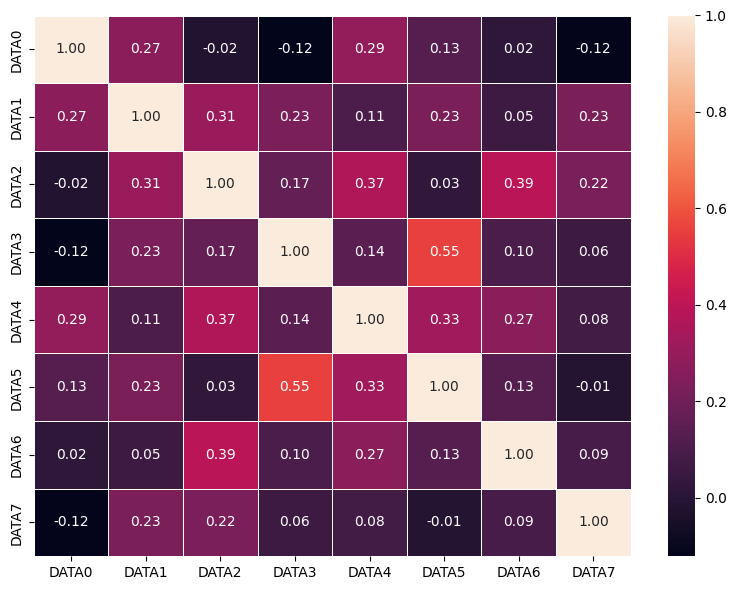

In [30]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Create directory for images if it doesn't exist
# image_dir = os.path.join("..", "images", "fuzzy")
# os.makedirs(image_dir, exist_ok=True)


# Assuming 'correlation_matrix' is already computed
fig, ax = plt.subplots(figsize=(8, 6))  # Set fixed width (10) and height (8)

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=0.5, ax=ax)

# Save the plot as a PNG image with a fixed size
plt.tight_layout()  # Ensures proper layout
plt.savefig(os.path.join("correlation_matrix_heatmap.pdf"), format="pdf", bbox_inches='tight')


# Show the plot
plt.show()



In [31]:
df_9 = df_8.copy()

# Realistic Scenario with no CAN ID included

## Algorithm Selection XGB

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:28:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9999973950599917
Confusion Matrix:
 [[669402      1]
 [     1  98368]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    669403
           1       1.00      1.00      1.00     98369

    accuracy                           1.00    767772
   macro avg       1.00      1.00      1.00    767772
weighted avg       1.00      1.00      1.00    767772


ROC AUC Score: 1.0000


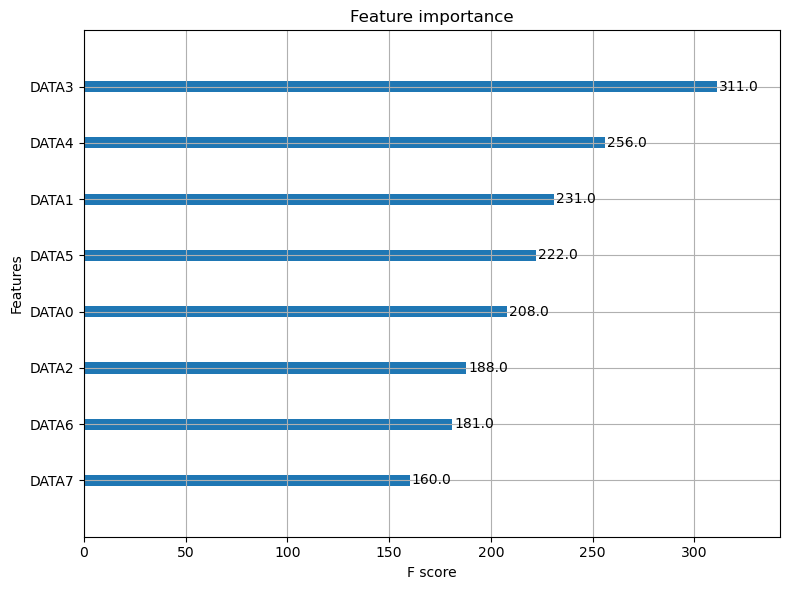

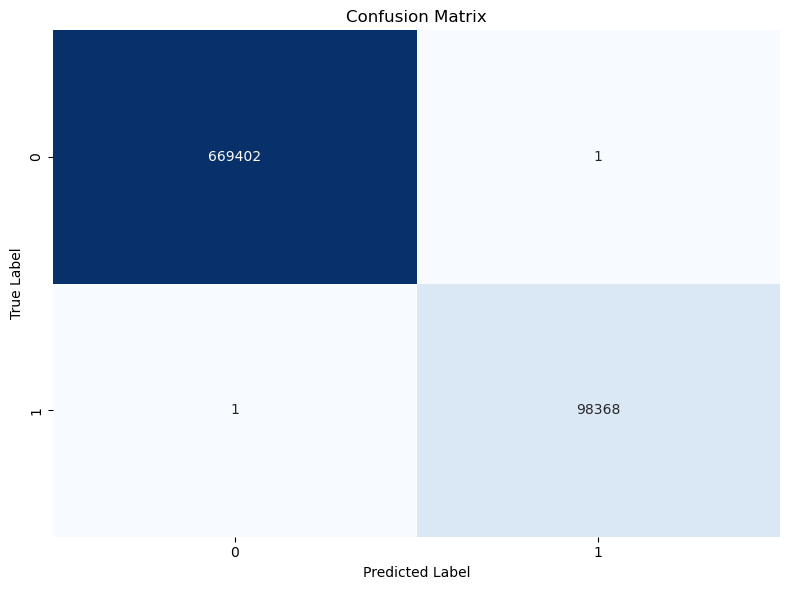

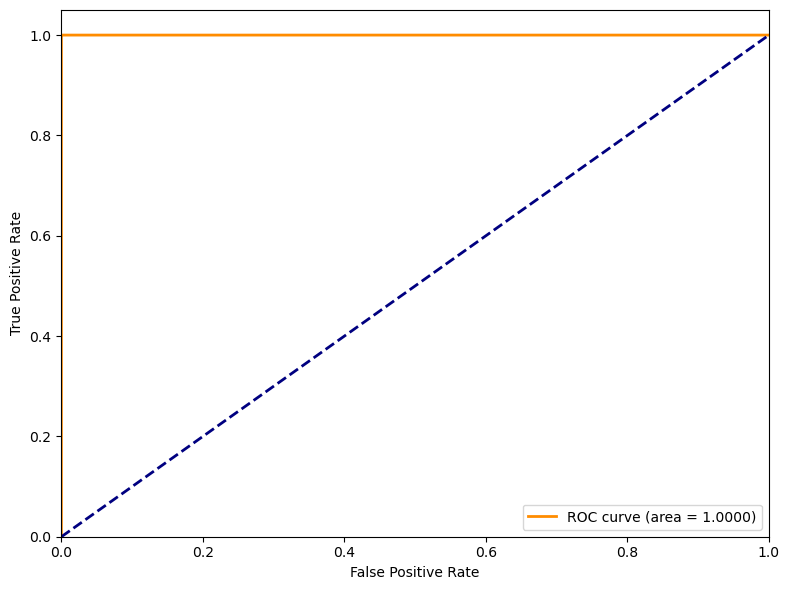

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Load data
df = df_9.drop(columns=['Timestamp']).copy()

# 1. Preprocessing
# Convert CAN ID to numerical (already done as 0 for attacks)
df['CAN ID'] = df['CAN ID'].astype('int64')

# 2. Define features and target variable
X = df.drop(['Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
y = df['Flag']

# 3. Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# 4. Initialize XGBoost with realistic parameters
model = xgb.XGBClassifier(
    scale_pos_weight=8,
    objective='binary:logistic',
    eval_metric='aucpr',
    max_depth=6,  # Prevent overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 5. Train the model
model.fit(X_train, y_train)

# 6. Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Print metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 7. Feature Importance
plt.figure(figsize=(8, 6))
xgb.plot_importance(model, ax=plt.gca())
plt.tight_layout()
plt.savefig(os.path.join("feature_importance_1.pdf"), format="pdf", bbox_inches='tight')
plt.show()
# 1. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig("confusion_matrix_1.pdf", format="pdf", bbox_inches='tight')
plt.show()

# 2. Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curve_1.pdf", format="pdf", bbox_inches='tight')

plt.show()


##  Advanced Feature Engineering

Index(['Timestamp', 'CAN ID', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4',
       'DATA5', 'DATA6', 'DATA7', 'Flag'],
      dtype='object')


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    669769
           1       1.00      1.00      1.00     98003

    accuracy                           1.00    767772
   macro avg       1.00      1.00      1.00    767772
weighted avg       1.00      1.00      1.00    767772

ROC AUC Score: 1.0000
Optimal Decision Threshold: 0.00
New Optimal Threshold: 0.29


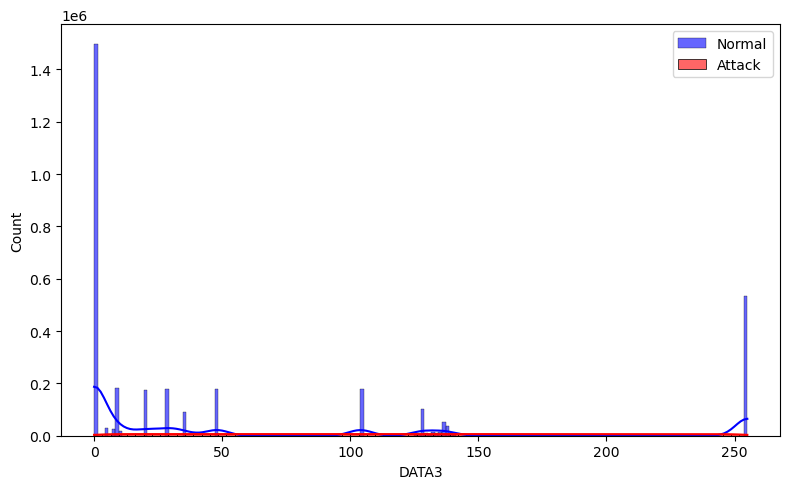

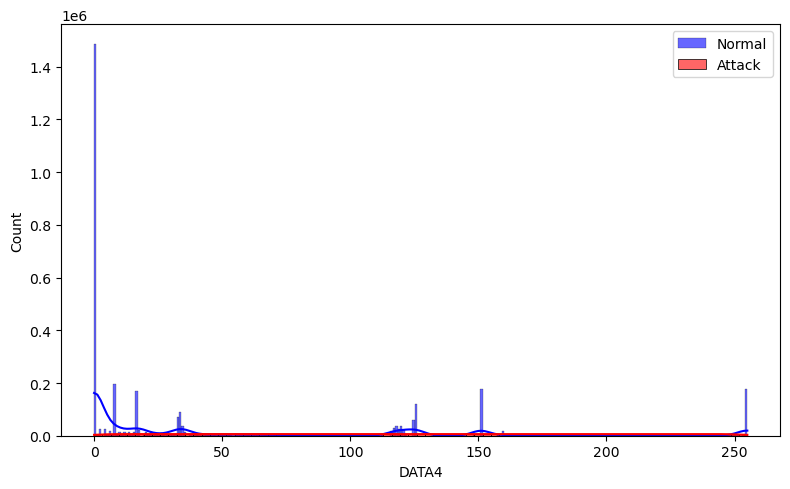

         DATA01_XOR    DATA01_SUM    DATA57_XOR
count  3.838859e+06  3.838859e+06  3.838859e+06
mean   8.350725e+01  1.253096e+02  9.938677e+01
std    7.987674e+01  1.273269e+02  8.596705e+01
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    2.000000e+01  3.200000e+01  2.000000e+00
50%    5.600000e+01  6.400000e+01  7.900000e+01
75%    1.460000e+02  2.230000e+02  1.760000e+02
max    2.550000e+02  5.100000e+02  2.550000e+02


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:04:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    669769
           1       1.00      1.00      1.00     98003

    accuracy                           1.00    767772
   macro avg       1.00      1.00      1.00    767772
weighted avg       1.00      1.00      1.00    767772



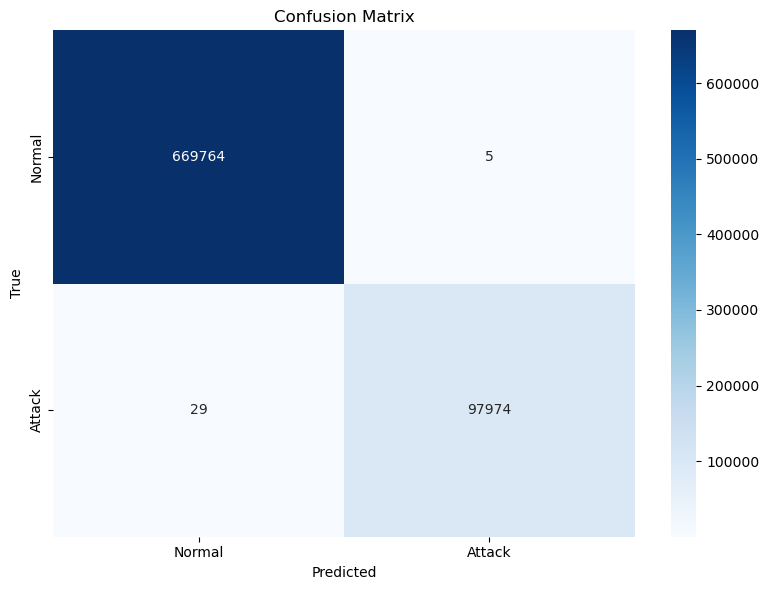

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import xgboost as xgb

# Load dataset
df = df_9.copy()
print(df.columns)

# Ensure numeric conversion
for col in ['DATA1', 'DATA3', 'DATA4', 'DATA5']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


# Define feature columns and target
features = ['DATA1', 'DATA3', 'DATA4', 'DATA5']
X = df[features]
y = df['Flag']  # Target: 1 = Attack, 0 = Normal

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability scores

# Performance Metrics
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Precision-Recall Curve & Optimal Threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
target_recall = 0.95
idx = np.argmax(recall >= target_recall)
optimal_threshold = thresholds[idx]
print(f"Optimal Decision Threshold: {optimal_threshold:.2f}")

best_idx = np.argmax(precision * recall)  # F1-score based tuning
best_threshold = thresholds[best_idx]
print(f"New Optimal Threshold: {best_threshold:.2f}")

# Create directory for images if it doesn't exist
image_dir = os.path.join("..", "images", "fuzzy")
os.makedirs(image_dir, exist_ok=True)

# Function to plot distributions
def plot_distribution(feature):
    plt.figure(figsize=(8, 5))
    sns.histplot(df[df['Flag'] == 0][feature], label='Normal', color='blue', kde=True, alpha=0.6)
    sns.histplot(df[df['Flag'] == 1][feature], label='Attack', color='red', kde=True, alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(f"{feature}_distribution.pdf"), format="pdf", bbox_inches='tight')
    plt.show()

# Plot distributions separately
for feature in ['DATA3', 'DATA4']:
    plot_distribution(feature)

# Feature Engineering (Bitwise & Arithmetic Transformations)
df['DATA34_XOR'] = df['DATA3'] ^ df['DATA4']
df['DATA34_SUM'] = df['DATA3'] + df['DATA4']
df['DATA45_XOR'] = df['DATA4'] ^ df['DATA5']

print(df[['DATA34_XOR', 'DATA34_SUM', 'DATA45_XOR']].describe())

# Train again with engineered features
X_new = df[['DATA0', 'DATA1', 'DATA5', 'DATA7', 'DATA01_XOR', 'DATA01_SUM', 'DATA57_XOR']]
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
model.fit(X_train_new, y_train)

# Evaluate again
y_pred_new = model.predict(X_test_new)
print(classification_report(y_test, y_pred_new))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_2.pdf"), format="pdf", bbox_inches='tight')
plt.show()


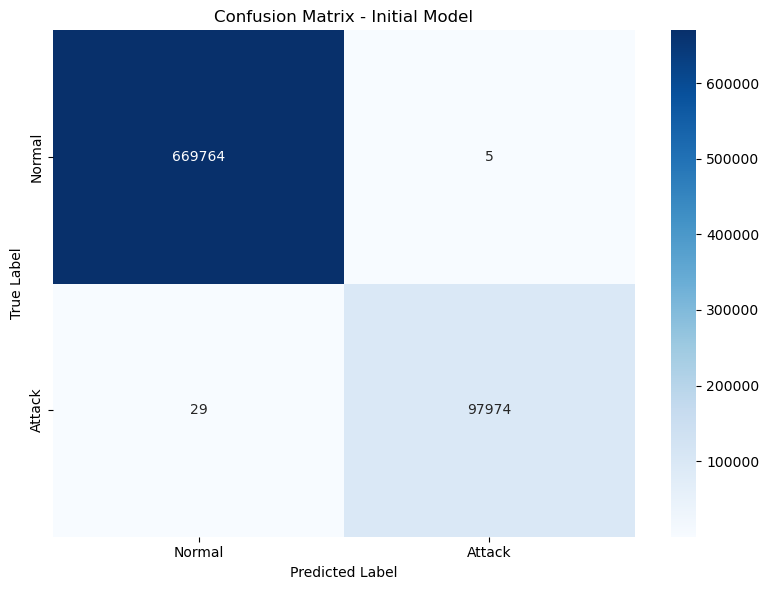

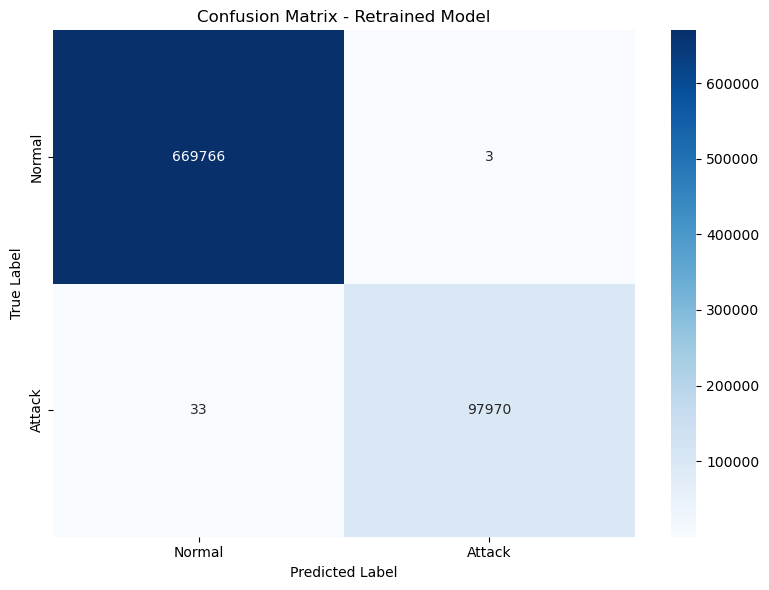

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initial Model Confusion Matrix
cm_initial = confusion_matrix(y_test, y_pred)

# Plot Initial Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_initial, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_initial.pdf"), format="pdf", bbox_inches='tight')
plt.show()

# Retrained Model Confusion Matrix
cm_retrained = confusion_matrix(y_test, y_pred_new)

# Plot Retrained Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_retrained, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_retrained.pdf"), format="pdf", bbox_inches='tight')
plt.show()


In [51]:
df_9.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478196e+09,688,255,127,0,5,73,0,0,0,0
1,1.478196e+09,2,0,0,0,0,0,1,7,21,0
2,1.478196e+09,339,0,33,16,255,0,255,0,0,0
3,1.478196e+09,304,25,128,0,255,254,127,7,96,0
4,1.478196e+09,305,23,128,0,0,101,127,7,159,0


## Temporal Features

Average Accuracy: 1.0000
Average ROC AUC Score: 1.0000

Average Confusion Matrix:
 [[3347006       6]
 [      3 3347009]]

Classification Report (Example Fold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    669403
           1       1.00      1.00      1.00    669402

    accuracy                           1.00   1338805
   macro avg       1.00      1.00      1.00   1338805
weighted avg       1.00      1.00      1.00   1338805



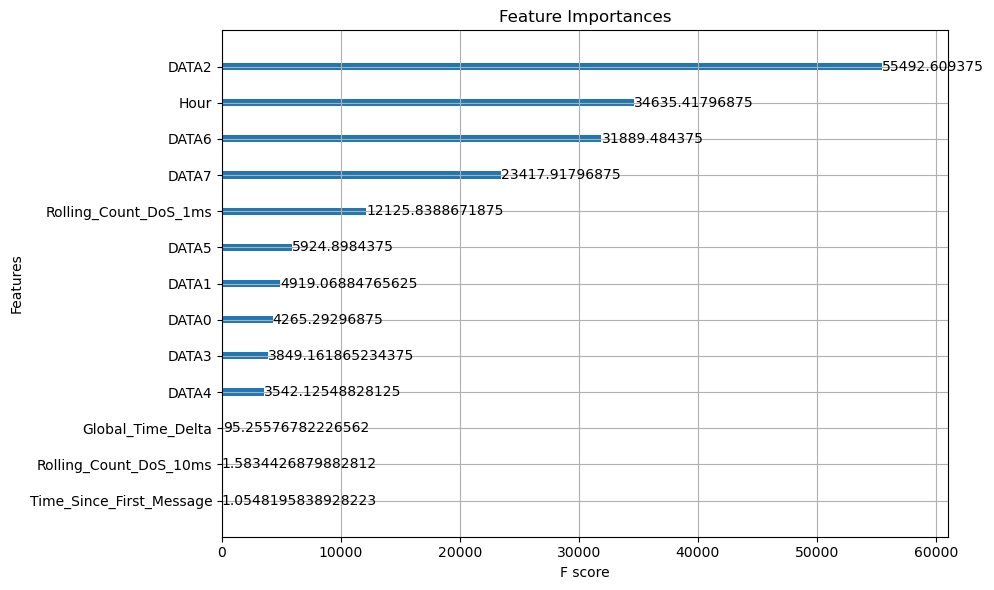

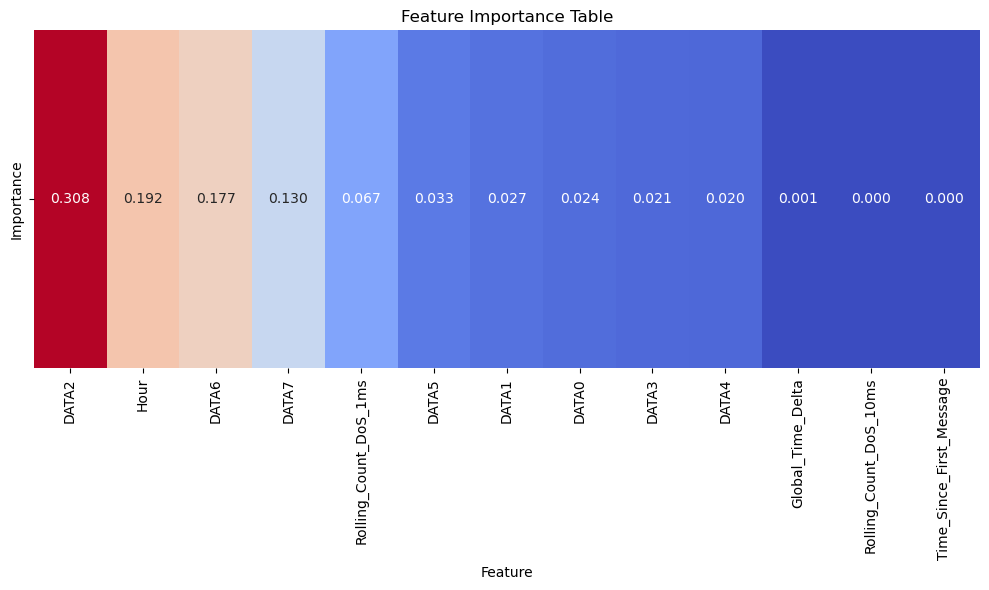

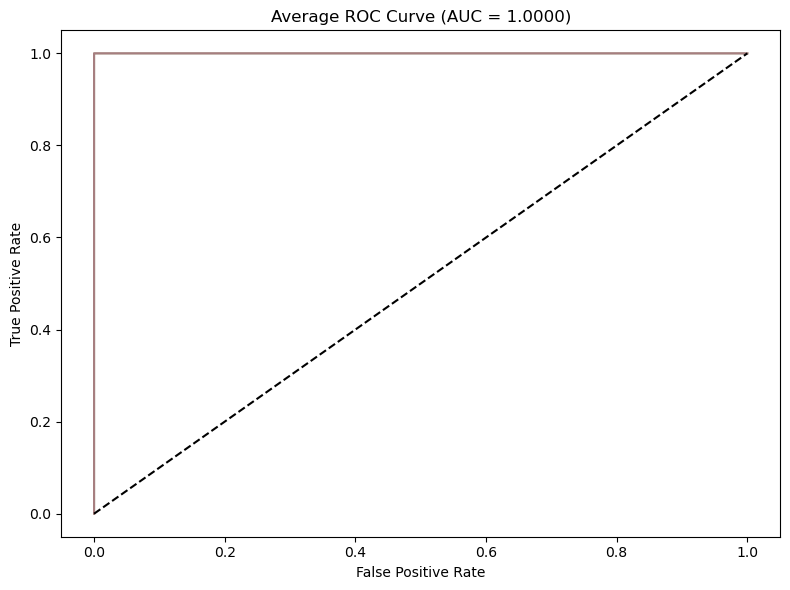

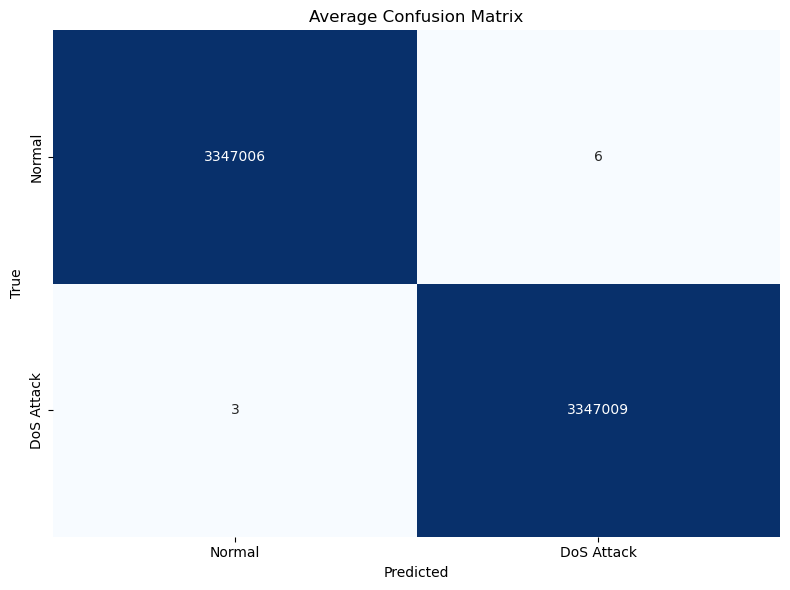

: 

In [59]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE


# Load data
df = df_9.copy()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.sort_values('Timestamp').reset_index(drop=True)
df.set_index('Timestamp', inplace=True)

# Feature Engineering
df['Global_Time_Delta'] = df.index.to_series().diff().dt.total_seconds().fillna(0)
df['Rolling_Count_DoS_1ms'] = df.rolling('1ms').count()['CAN ID']
df['Rolling_Count_DoS_10ms'] = df.rolling('10ms').count()['CAN ID']
df['Rolling_Count_DoS_1ms'] = df.rolling('0.3ms').count()['CAN ID']
df['Hour'] = df.index.hour
df['Time_Since_First_Message'] = (df.index - df.index.min()).total_seconds()

# Prepare features
X = df.drop(['Flag', 'CAN ID'], axis=1)
y = df['Flag']

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Initialize XGBoost
model = xgb.XGBClassifier(
    scale_pos_weight=10, 
    objective='binary:logistic',
    eval_metric='aucpr',
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics storage
roc_auc_scores, accuracies, classification_reports, confusion_matrices = [], [], [], []
all_fpr, all_tpr = [], []

# Cross-validation loop
for train_index, test_index in kf.split(X_res, y_res):
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracies.append(accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_proba))
    classification_reports.append(classification_report(y_test, y_pred))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    all_fpr.append(fpr)
    all_tpr.append(tpr)

# Compute final averages
avg_accuracy = np.mean(accuracies)
avg_roc_auc = np.mean(roc_auc_scores)
avg_conf_matrix = np.sum(confusion_matrices, axis=0).astype(int)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average ROC AUC Score: {avg_roc_auc:.4f}")
print(f"\nAverage Confusion Matrix:\n {avg_conf_matrix}")
print("\nClassification Report (Example Fold):\n", classification_reports[0])

# Feature Importance
importances = model.get_booster().get_score(importance_type='gain')
normalized_importances = {k: v / sum(importances.values()) for k, v in importances.items()}
feature_importance_df = pd.DataFrame(list(normalized_importances.items()), columns=['Feature', 'Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='gain', ax=plt.gca())
plt.tight_layout()
plt.savefig(os.path.join("feature_importance_3.pdf"), format="pdf", bbox_inches='tight')
plt.show()

# Heatmap of Feature Importance
plt.figure(figsize=(10, 6))
sns.heatmap(feature_importance_df.set_index('Feature').T, annot=True, cmap='coolwarm', fmt='.3f')
plt.tight_layout()
plt.savefig("feature_importance_heatmap_3.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Average ROC Curve
plt.figure(figsize=(8, 6))
for fpr, tpr in zip(all_fpr, all_tpr):
    plt.plot(fpr, tpr, alpha=0.3)  # Plot all folds
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()
plt.savefig(os.path.join("roc_curve_3.pdf"), format="pdf", bbox_inches='tight')
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'DoS Attack'], yticklabels=['Normal', 'DoS Attack'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_3.pdf"), format="pdf", bbox_inches='tight')
plt.show()


In [ ]:
# Algorithm RF
## Without SMOTE

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()

# 1. Preprocessing
# Convert CAN ID to categorical (important for tree models)
df['CAN ID'] = df['CAN ID'].astype('category')

# 2. Split data
X = df.drop('Flag', axis=1)
y = df['Flag']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# 3. Initialize Random Forest with class weighting
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Handles imbalance
    max_depth=10,             # Prevent overfitting
    n_jobs=-1,                # Use all cores
    random_state=42
)

# 4. Train model
rf.fit(X_train, y_train)

# 5. Evaluate
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 6. Feature Importance
features = X.columns
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create DataFrame
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances, 'Std': std})
fi_df = fi_df.sort_values('Importance', ascending=False)

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_rf_1.pdf"), format="pdf", bbox_inches='tight')
plt.show()

# Plot
plt.figure(figsize=(10,6))
plt.bar(fi_df['Feature'], fi_df['Importance'], yerr=fi_df['Std'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join("feature_imp_rf_1.pdf"), format="pdf", bbox_inches='tight')
plt.show()


## Class Weight Tuning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()


# 2. Split data
X = df.drop(['Timestamp', 'Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
y = df['Flag']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# 3. Manually calculate class weights based on the exact class ratio (~5.24:1)
# ratio = 3_078_250 / 587_521  # approximately 5.24
ratio = 10
class_weights = {0: 1, 1: ratio}  # Assign higher weight to minority class

# 4. Initialize Random Forest with manually calculated class weights
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weights,  # using manual weights instead of 'balanced'
    max_depth=10,                # Prevent overfitting
    n_jobs=-1,                   # Use all available cores
    random_state=42
)

# 5. Train the model
rf.fit(X_train, y_train)

# 6. Evaluate the model
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 7. Feature Importance
features = X.columns
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create DataFrame for feature importances
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances, 'Std': std})
fi_df = fi_df.sort_values('Importance', ascending=False)

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_rf_2.pdf"), format="pdf", bbox_inches='tight')
plt.show()

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(fi_df['Feature'], fi_df['Importance'], yerr=fi_df['Std'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join("feature_imp_rf.pdf"), format="pdf", bbox_inches='tight')
plt.show()


In [ ]:
## Threshold Adjustment

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()


X = df.drop(['Timestamp', 'Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
y = df['Flag']

# 3. Split data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# 4. Initialize XGBoost classifier with built-in imbalance handling
model = xgb.XGBClassifier(
    scale_pos_weight=5.24,      # Directly accounts for the class imbalance ratio
    objective='binary:logistic',
    eval_metric='aucpr',        # Optimize for precision-recall AUC
    use_label_encoder=False,    # Suppress a warning regarding label encoding
    random_state=42
)

# 5. Train the model
model.fit(X_train, y_train)

# 6. Get predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# 7. Threshold Adjustment: Optimize decision threshold using precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 scores for each threshold; note that thresholds array is one element shorter than precision/recall
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # avoid division by zero
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Optimal Threshold (based on maximum F1): {best_threshold:.4f}")

# Use the optimal threshold to make final predictions
y_pred = (y_proba >= best_threshold).astype(int)

# 8. Evaluate the model with the adjusted threshold
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_rf_3.pdf"), format="pdf", bbox_inches='tight')

plt.show()


## With SMOTE and KFold

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE  # Import SMOTE

# Ensure directory exists for saving plots
image_dir = "../images"
os.makedirs(image_dir, exist_ok=True)

# Load data
df = df_9.copy()

# Prepare Features and Target
X = df.drop(['Timestamp','Flag', 'CAN ID'], axis=1)  # Remove 'Flag' (target) and 'CAN ID' (identifier)
y = df['Flag']

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Initialize Random Forest with Class Weighting
rf = RandomForestClassifier(
    n_estimators=10,
    class_weight='balanced',  # Handles imbalance
    max_depth=10,             # Prevent overfitting
    n_jobs=-1,                # Use all CPU cores
    random_state=42
)

# Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics storage
roc_auc_scores, accuracies, classification_reports, confusion_matrices = [], [], [], []
all_fpr, all_tpr = [], []

# Cross-validation loop
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to the training set only
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Train the Model on Resampled Data
    rf.fit(X_train_res, y_train_res)

    # Make predictions
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:,1]  # Get probability of the positive class

    # Store performance metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_proba))
    classification_reports.append(classification_report(y_test, y_pred))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    all_fpr.append(fpr)
    all_tpr.append(tpr)

# Compute final averages
avg_accuracy = np.mean(accuracies)
avg_roc_auc = np.mean(roc_auc_scores)
avg_conf_matrix = np.sum(confusion_matrices, axis=0).astype(int)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average ROC AUC Score: {avg_roc_auc:.4f}")
print(f"\nAverage Confusion Matrix:\n {avg_conf_matrix}")
print("\nClassification Report (Example Fold):\n", classification_reports[0])

# Average ROC Curve
plt.figure(figsize=(8, 6))
for fpr, tpr in zip(all_fpr, all_tpr):
    plt.plot(fpr, tpr, alpha=0.3)  # Plot all folds
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Average ROC Curve (AUC = {avg_roc_auc:.4f})')
plt.tight_layout()
plt.savefig(os.path.join(image_dir, "roc_curve_rf.pdf"), format="pdf", bbox_inches='tight')
plt.show()

# Average Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'DoS Attack'], yticklabels=['Normal', 'DoS Attack'])
plt.title('Average Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(image_dir, "confusion_matrix_rf.pdf"), format="pdf", bbox_inches='tight')
plt.show()


## SMOTE but no KFold

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE  # Import SMOTE
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()

# 1. Prepare Features and Target
X = df.drop(['Timestamp','Flag', 'CAN ID'], axis=1)  # Remove 'Timestamp' 'Flag' (target) and 'CAN ID' (identifier)
y = df['Flag']

# 2. Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# 3. Apply SMOTE for Oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Print class distribution before and after SMOTE
print(f"Before SMOTE: {np.bincount(y_train)}")
print(f"After SMOTE: {np.bincount(y_train_res)}")

# 4. Initialize Random Forest with Class Weighting
rf = RandomForestClassifier(
    n_estimators=20,
    class_weight='balanced',  # Handles imbalance
    max_depth=10,             # Prevent overfitting
    n_jobs=-1,                # Use all CPU cores
    random_state=42
)

# 5. Train the Model on Resampled Data
rf.fit(X_train_res, y_train_res)

# 6. Evaluate on Test Set
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]  # Get probability of the positive class

# Performance Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")



# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_rf_2.pdf"), format="pdf", bbox_inches='tight')
plt.show()


# Before SMOTE: [2462599  470017]
# After SMOTE: [2462599 2462599]
# Accuracy: 0.9766351953341317
# Confusion Matrix:
#  [[598520  17130]
#  [     0 117504]]
# Classification Report:
#                precision    recall  f1-score   support

#            0       1.00      0.97      0.99    615650
#            1       0.87      1.00      0.93    117504

#     accuracy                           0.98    733154
#    macro avg       0.94      0.99      0.96    733154
# weighted avg       0.98      0.98      0.98    733154


# SVM Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = df_9.copy()

# 1. Prepare Features and Target
X = df.drop(['Timestamp', 'Flag', 'CAN ID'], axis=1)  # Remove 'Flag' (target) and 'CAN ID' (identifier)
y = df['Flag']

# 2. Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# Print class distribution before splitting
print(f"Class distribution in training set: {np.bincount(y_train)}")

# 3. Initialize SVM with Class Weighting
svm = SVC(
    kernel='rbf',            # 'linear' can be used for high-dimensional sparse data
    class_weight='balanced',  # Handle class imbalance
    probability=True,         # Enable probability estimates (needed for ROC AUC)
    random_state=42
)

# 4. Train the Model
svm.fit(X_train, y_train)

# 5. Evaluate on Test Set
y_pred = svm.predict(X_test)
y_proba = svm.predict_proba(X_test)[:, 1]  # Get probability of the positive class

# Performance Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig(os.path.join("confusion_matrix_svm_1.pdf"), format="pdf", bbox_inches='tight')
plt.show()

